In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

In [2]:
c0 = -1
c1 = 0.7
c2 = 0.3
c3 = 3
c4 = 0.5
alpha = 1

def general_loss_function(theta):
    return c0 * np.cos(c1*theta) + c2 * np.sin(c3 * (theta - c4))

def strongly_convex_loss_function(theta):
    return c2*theta**2 - c1 * theta - alpha

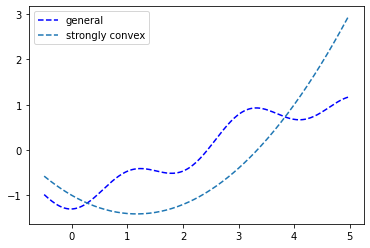

In [3]:
# evenly sampled time at 200ms intervals
mus = np.arange(-0.5, 5., 0.02)

# red dashes, blue squares and green triangles
plt.plot(mus, general_loss_function(mus), 'b--', label='general')
plt.plot(mus, strongly_convex_loss_function(mus), '--', label='strongly convex')
plt.legend()
plt.show()

In [4]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, logging_samples, logging_losses, logging_propensities, lambd=0.1):
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + lambd * std

def optimist_loss(param, logging_samples, logging_losses, logging_propensities, lambd=0.1):
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean - lambd * std

In [5]:
loss_mode = 'convex'
loss_function = general_loss_function if loss_mode == 'general' else strongly_convex_loss_function 

In [6]:
def safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args):

    lbfgsb = jaxopt.ScipyBoundedMinimize(fun=loss_fun, method="l-bfgs-b")

    min_mu = mus[confidence_region].min()
    max_mu = mus[confidence_region].max()

    lower_bounds = jnp.array(min_mu, dtype='float32')
    upper_bounds = jnp.array(max_mu, dtype='float32')
    bounds = (lower_bounds, upper_bounds)

    lbfgsb_sol = lbfgsb.run(init_parameter, bounds, *args).params
    return lbfgsb_sol


def optimize(loss_fun, init_parameter, logging_loss_threshold, args):

    lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B")

    lbfgs_sol = lbfgsb.run(init_parameter, *args).params
    
    lbfgs_fun_val = lbfgsb.run(init_parameter, *args).state.fun_val
    
    return lbfgs_sol, lbfgs_fun_val

In [7]:

def plot_dynamic(estimates, optimized_mus, mode='conservative'):
    
    ### Estimates
    estimate_means = estimates['means']
    estimate_stds = estimates['stds']
    ess_diagnostics = estimates['ess']
#     upper_bounds = estimate_means+estimate_stds
    confidence_region = estimates['confidence_region']
    number_episodes = len(optimized_mus)
    
    ### Create figure
    plt.figure(figsize=(16, 12))

    ### Loss function and its estimate, its confidence bound
    plt.plot(mus, loss_function(mus), 'b-.', label='loss function')
    plt.plot(mus, estimate_means, '-.', label='estimated loss')
    plt.fill_between(mus, (estimate_means-estimate_stds), (estimate_means+estimate_stds), color='b', alpha=.1, label='confidence set')

    ### Confidence/constrained region
    plt.axhline(y=logging_loss_threshold, color='purple', linestyle='-', label=r'$(1+\varepsilon)L(\mu_0)$')
    plt.fill_between(mus, -3.5, 2.5, where=(ess_diagnostics<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
    plt.fill_between(mus, -3.5, 2.5, where=confidence_region,
                    color='lightgreen', alpha=0.5, label='safe region')

    ### Logging mu and associates
    for index in range(number_episodes-1):
        mu = optimized_mus[index]
        plt.axvline(x=mu, color='limegreen', linestyle='--', label=r'$\mu_{}$'.format(index))
    index, mu = len(optimized_mus)-1, optimized_mus[-1] # last value is in black
    plt.axvline(x=mu, color='k', linestyle='--', label=r'$\mu_{}$'.format(index))

    ### Legends, labels, ticks, save figure
    plt.legend(loc='upper left')
    plt.xlabel(r'$\mu$')
    ticks_x, ticks_label = [0, 2], ['0', '2']
    ticks_x += optimized_mus
    ticks_label += ['$\mu_{}$'.format(index) for index in range(number_episodes)]
    plt.xticks(ticks_x, ticks_label)
    plt.ylim(-3.5, 2.5)
    plt.title('Rollout {} - {} loss'.format(number_episodes-1, mode))
    plt.savefig('{}_scrm_{}.pdf'.format(mode, number_episodes-1))
    plt.show()

### Data

In [8]:
# logging_mu = 3
# logging_scale = 0.3
# n_samples = 10000
# rng = np.random.RandomState(123)
# logging_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
# logging_losses = loss_function(logging_samples)
# logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
# logging_propensities = logging_pdf(logging_samples)
# logging_loss = np.mean(logging_losses)
# epsilon = 0.9
# logging_loss_threshold = logging_loss*(1+epsilon)
# logging_data = logging_samples, logging_losses, logging_propensities

# mu = logging_mu
# optimized_mus = [mu]
# M = 15

In [9]:
# epsilon = 0.2
# logging_loss_threshold = logging_loss*(1+epsilon)
# lambd = 30

In [10]:
# logging_data = logging_samples, logging_losses, logging_propensities
# mus = np.arange(-0.5, 5., 0.1)

# def get_estimates(mu, logging_data):

#     def estimates(mu, logging_data):
#         logging_samples, logging_losses, logging_propensities = logging_data
#         running_pdf = norm(loc=mu, scale=logging_scale).pdf
#         ### DANGER ICI LES PROPENSITIES SONT FAUSSES
#         importance_weights = running_pdf(logging_samples)/logging_pdf(logging_samples)
#         ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
#         return np.mean(logging_losses * importance_weights), lambd*np.std(logging_losses * importance_weights)/np.sqrt(n_samples), ess_diagnostic

#     estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
#     estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
#     upper_bounds = estimate_means+estimate_stds
#     confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

#     estimates = {
#         'means': estimate_means,
#         'stds': estimate_stds,
#         'ess': ess_diagnostics,
#         'confidence_region': confidence_region
#     }

#     return estimates

# estimates = get_estimates(mu, logging_data)

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# lambd = logging_samples.mean()


# # axs[0].plot(nus, ne_star, c='black', label='$n^{*}_{e}/n$')
# axs[0].scatter(mus, estimates['ess'], c='blue', marker='+', label='$n^{*}_{e}/n$')
# axs[0].set_yscale('log')
# axs[0].fill_between(mus, 0.0001, 2, where=(estimates['ess']<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
# axs[0].set_ylim(0.0001, 2)

# axs[0].set_xlabel('$\mu$')
# axs[0].set_title('Effective sample size $n^{*}_{e}/n$')
# # axs[0].axhline(0.01*n, linestyle='--', label='$0.01*n$', c='navy')
# axs[0].plot(mus, 0.01*np.ones_like(mus), c='black', label='Threshold')
# axs[0].axvline(lambd, linestyle='--', c='royalblue')
# axs[0].legend(loc='upper right')
# axs[0].set_xticks([logging_mu])

# axs[1].scatter(mus, estimates['means'], marker='.', color='blue', label='$\hat{L}(\mu)$')
# axs[1].errorbar(mus, estimates['means'], yerr=estimates['stds'], linestyle='', color='lightsteelblue')
# axs[1].set_xlabel('$\mu$')
# axs[1].set_title('Estimation $\hat{L}$ and confidence intervals')
# axs[1].axvline(lambd, linestyle='--', c='royalblue')
# axs[1].fill_between(mus, -0.5, 1, where=(estimates['ess']<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
# axs[1].set_ylim(-0.5, 1)
# axs[1].legend(loc='lower right')
# axs[1].set_xticks([logging_mu])
# # axs[2].scatter(nus, empirical_means, color='blue', label='Empirical mean')
# # axs[2].plot(nus, np.ones_like(nus), c='black', label='Theoretical mean')
# # axs[2].set_xlabel('$\mu$')
# # axs[2].set_title('Importance sampling weights mean $\dfrac{1}{n} \sum w_i$')
# # axs[2].axvline(lambd, linestyle='--', label='$\mu_{\pi_0}$ mode', c='royalblue')
# # axs[2].legend(loc='lower right')
# axs[0].set_xlim(1.5, 4.5)
# axs[1].set_xlim(1.5, 4.5)

# plt.setp(axs, xticks=[logging_mu],
#          xticklabels=['$\mu_0$'])
# plt.savefig('diagnostics.pdf',  pad_inches=0, bbox_inches='tight')


In [11]:
# ### Estimates
# estimate_means = estimates['means']
# estimate_stds = estimates['stds']
# ess_diagnostics = estimates['ess']
# #     upper_bounds = estimate_means+estimate_stds
# confidence_region = estimates['confidence_region']

# y_low = -1
# y_up = 1.5
# ### Create figure
# # plt.figure(figsize=(16, 12))

# ### Loss function and its estimate, its confidence bound
# plt.plot(mus, loss_function(mus), 'b-.', label='loss function')
# plt.plot(mus, estimate_means, '-.', label='estimated loss')
# plt.fill_between(mus, (estimate_means-estimate_stds), (estimate_means+estimate_stds), color='b', alpha=.1, label='confidence set')

# ### Confidence/constrained region
# plt.axhline(y=logging_loss_threshold, color='purple', linestyle='-', label=r'$(1+\varepsilon)L(\mu_0)$')
# plt.fill_between(mus, y_low, y_up, where=(ess_diagnostics<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
# plt.fill_between(mus, y_low, y_up, where=confidence_region,
#                 color='lightgreen', alpha=0.5, label='$S_0(M)$')

# ### Logging mu and associates
# plt.axvline(x=logging_mu, color='k', linestyle='--', label=r'$\mu_0$')

# ### Legends, labels, ticks, save figure
# plt.legend(loc='lower right')
# plt.xlabel(r'$\mu$')
# plt.xlim(1.8, 4.5)
# ticks_x, ticks_label = [2, logging_mu], ['2', '$\mu_0$']
# plt.xticks(ticks_x, ticks_label)
# plt.ylim(y_low, y_up)
# # plt.title('Rollout {} - {} loss'.format(number_episodes-1, mode))
# plt.savefig('safe_crm.pdf')
# plt.show()

In [12]:
class CRMDataset(object):
    
    def __init__(self):

        self.propensities_ = []
        self.actions_ = []
        self.rewards_ = []
        self.features_ = []
        
        self.propensities_np = None
        self.actions_np = None
        self.rewards_np = None
        self.features_np = None

        self.check()
        
    def __str__(self):
        if not self.propensities_np:
            return '<CRMDataset>'
        self._generate_numpys()
        return '<CRMDataset propensities:%s actions:%s rewards:%s features:%s>' % (
            self.propensities_np.shape,
            self.actions_np.shape,
            self.rewards_np.shape,
            self.features_np.shape
        )
    
    __repr__ = __str__
        
    def check(self):
        assert len(self.features_) == len(self.propensities_) == len(self.rewards_) == len(self.actions_)
        assert type(self.propensities_) == type(self.actions_) == type(self.rewards_) == type(self.features_) == list        
        
    def __len__(self):
        return len(self.propensities_)
        
    def _generate_numpys(self):
        if self.propensities_np is not None and len(self.propensities_np) == len(self.propensities_):
            return        
        self.propensities_np = np.vstack(self.propensities_)
        self.actions_np = np.vstack(self.actions_)
        self.rewards_np = np.vstack(self.rewards_)
        self.features_np = np.vstack(self.features_)
        
    @property
    def actions(self):
#         self._generate_numpys()
        return self.actions_np

    @property
    def propensities(self):
#         self._generate_numpys()
        return self.propensities_np
    
    @property
    def rewards(self):
#         self._generate_numpys()
        return self.rewards_np
    
    @property
    def features(self):
#         self._generate_numpys()
        return self.features_np
        
#     def update_from_supervised_dataset(self, X, y, probas, n_samples=4, labels=labels):
#         # X is (n,d)
#         # y is (n,k)
#         # probas is (n,k)

#         assert len(X) == len(y) == len(probas), (len(X) , len(y) , len(probas))

#         for i in range(len(X)):

#             for k in range(n_samples):

#                 chosen_actions = np.array([np.random.binomial(1, p=probas[i,j]) for j in labels])
#                 self.actions_ += [chosen_actions]
#                 self.propensities_ += [probas[i,:]]
#                 self.features_ += [X[i,:]]
#                 self.rewards_ += [sum(int(y[i,j] == chosen_actions[j]) for j in labels)]
                
#         self._generate_numpys()
#         return self

class LossHistory(object):
    
    def __init__(self, name, ref_crm_dataset, X_test, y_test):
        self.name = name
        self.ref_crm_dataset = ref_crm_dataset
        self.X_test = X_test
        self.y_test = y_test
        self.crm_loss = []
        self.online_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.rewards = []
        
    def update(self, crm_dataset: CRMDataset, beta, online_loss, crm_loss):
        self.betas += [beta]
        self.online_loss += [online_loss]
        self.crm_loss += [crm_loss]
        self.n_samples += [len(crm_dataset)]
        self.n_actions += [np.sum(crm_dataset.actions_)]
        self.rewards += [np.sum(crm_dataset.rewards_)]
        
    def show_last(self):
        print(
            '<', self.name,
            'CRM loss: %.5f' % self.crm_loss[-1],
            'Online loss: %.5f' % self.crm_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % self.n_samples[-1],
            '|A|=%d' % self.n_actions[-1],
            '|R|=%d' % self.rewards[-1],
            '>',
            file=sys.stderr
        )

# Experiment

In [19]:
logging_mu = 3
logging_scale = 0.3

def get_logging_data(n_samples, random_seed=123):

    rng = np.random.RandomState(random_seed)
    action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
    losses = loss_function(action_samples)
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    propensities = logging_pdf(action_samples)
    loss = np.mean(losses)
    epsilon = 0.9
    logging_loss_threshold = loss*(1+epsilon)
    logging_data = action_samples, losses, propensities

    return logging_data, logging_loss_threshold

### Single round CRM

In [20]:
betas = []
single_crm_losses = []
single_online_losses = []

def single_crm_experiment(random_seed, plot=True):

    mode = 'conservative'

    loss_fun = conservative_loss if mode == 'conservative' else optimist_loss

    X_test, y_test = None, None
    ref_crm_dataset = CRMDataset()
    single_crm_loss_history = LossHistory("Single CRM", ref_crm_dataset, X_test, y_test)

    rng = np.random.RandomState(random_seed)
    T = 10000
    M = 1
    n_samples = T

    mu = logging_mu
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    optimized_mus = [mu]
    compteur = 0
    logging_data, logging_loss_threshold = get_logging_data(n_samples, random_seed)
    logging_samples, logging_losses, logging_propensities = logging_data
    logging_loss = np.mean(logging_losses)
    epsilon = 0.2
    logging_loss_threshold = logging_loss*(1+epsilon)

    def get_estimates(mu, logging_data, lambd=0.1):

        def estimates(mu, logging_data):
            logging_samples, logging_losses, logging_propensities = logging_data
            running_pdf = norm(loc=mu, scale=logging_scale).pdf
            ### DANGER ICI LES PROPENSITIES SONT FAUSSES
            importance_weights = running_pdf(logging_samples)/logging_propensities
            ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
            return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

        estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
        estimate_means, ess_diagnostics, estimate_stds = np.array(estimate_means), np.array(ess_diagnostics), np.array(estimate_stds)
        upper_bounds = estimate_means+lambd*estimate_stds
        confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

        estimates = {
            'means': estimate_means,
            'stds': lambd*estimate_stds,
            'ess': ess_diagnostics,
            'confidence_region': confidence_region
        }

        return estimates

    estimates = get_estimates(mu, logging_data)
    confidence_region = estimates['confidence_region']
    init_parameter = jnp.array(mu, dtype='float32')
    args = logging_data

    optimized_mu, loss_crm = optimize(loss_fun, init_parameter, logging_loss_threshold, args)
    optimized_mus.append(optimized_mu)
    if plot:
        plot_dynamic(estimates, optimized_mus)
    single_crm_loss = loss_crm._value
    
    mu = optimized_mu._value
    logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
    logging_losses = loss_function(logging_samples)
    single_online_loss = np.mean(logging_losses)
    
    return single_crm_loss, single_online_loss


for random_seed in range(10):
    crm_loss, online_loss = single_crm_experiment(random_seed, plot=False)
    single_crm_losses.append(crm_loss)
    single_online_losses.append(online_loss)
    

single_crm_loss, single_crm_loss_std = np.mean(single_crm_losses), np.std(single_crm_losses)
single_online_loss, single_online_loss_std = np.mean(single_online_losses), np.std(single_online_losses)


### Sequential CRM

In [21]:
histories = []
    
def sequential_crm_experiment(random_seed, plot=True):

    mode = 'conservative'
    loss_fun = conservative_loss if mode == 'conservative' else optimist_loss
    n_samples = 2

    T = 10000
    M = int(np.log(T)/np.log(2))

    mu = logging_mu
    optimized_mus = [mu]
    compteur = 0
    logging_data, logging_loss_threshold = get_logging_data(n_samples, random_seed)
    last_loss = 0

    X_test, y_test = None, None
    ref_crm_dataset = CRMDataset()
    seq_crm_loss_history = LossHistory("SCRM", ref_crm_dataset, X_test, y_test)
    rng = np.random.RandomState(random_seed)
    
    for m in range(M):

        compteur += n_samples
        def get_estimates(mu, logging_data, lambd=0.1):

            def estimates(mu, logging_data):
                logging_samples, logging_losses, logging_propensities = logging_data
                running_pdf = norm(loc=mu, scale=logging_scale).pdf
                ### DANGER ICI LES PROPENSITIES SONT FAUSSES
                importance_weights = running_pdf(logging_samples)/logging_propensities
                ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
                return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

            estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
            estimate_means, ess_diagnostics, estimate_stds = np.array(estimate_means), np.array(ess_diagnostics), np.array(estimate_stds)
            upper_bounds = estimate_means+lambd*estimate_stds
            confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

            estimates = {
                'means': estimate_means,
                'stds': estimate_stds,
                'ess': lambd*ess_diagnostics,
                'confidence_region': confidence_region
            }

            return estimates

        estimates = get_estimates(mu, logging_data)
        confidence_region = estimates['confidence_region']
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu, loss_crm = optimize(loss_fun, init_parameter, logging_loss_threshold, args)
        optimized_mus.append(optimized_mu)
        if plot:
            plot_dynamic(estimates, optimized_mus)

        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
        logging_losses = loss_function(logging_samples)
        logging_pdf = norm(loc=mu, scale=logging_scale).pdf
        logging_propensities = logging_pdf(logging_samples)


        logging_data = logging_samples, logging_losses, logging_propensities
        n_samples *= 2

        ## record
        online_loss = np.mean(logging_losses)
        seq_crm_loss_history.update(ref_crm_dataset, optimized_mu, online_loss, loss_crm)
        seq_crm_loss_history.show_last()
    
    return seq_crm_loss_history

for random_seed in range(10):
    seq_crm_loss_history = sequential_crm_experiment(random_seed, plot=False)
    histories.append(seq_crm_loss_history)
    
    

< SCRM CRM loss: -0.03692 Online loss: -0.03692 |beta|=2.78 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.28353 Online loss: -0.28353 |beta|=2.96 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.23801 Online loss: -0.23801 |beta|=2.64 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.66393 Online loss: -0.66393 |beta|=2.77 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.34877 Online loss: -1.34877 |beta|=2.06 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.35888 Online loss: -1.35888 |beta|=1.82 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.23931 Online loss: -1.23931 |beta|=1.87 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.24713 Online loss: -1.24713 |beta|=1.78 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.31157 Online loss: -1.31157 |beta|=1.55 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.33666 Online loss: -1.33666 |beta|=1.52 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.33923 Online loss: -1.33923 |beta|=1.53 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.33776 Online loss: -1.33776 |beta|=1.52 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.33673 Online loss: -1.33673 |beta|=1.53 n=0 

< SCRM CRM loss: -4.83400 Online loss: -4.83400 |beta|=2.38 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.15230 Online loss: -1.15230 |beta|=2.91 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.52336 Online loss: -0.52336 |beta|=2.75 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -2.68478 Online loss: -2.68478 |beta|=1.85 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.21228 Online loss: -1.21228 |beta|=1.89 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.29589 Online loss: -1.29589 |beta|=1.63 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.30757 Online loss: -1.30757 |beta|=1.64 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.30209 Online loss: -1.30209 |beta|=1.67 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.29643 Online loss: -1.29643 |beta|=1.68 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.29436 Online loss: -1.29436 |beta|=1.66 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -1.29877 Online loss: -1.29877 |beta|=1.67 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.44654 Online loss: -0.44654 |beta|=2.96 n=0 |A|=0 |R|=0 >
< SCRM CRM loss: -0.49415 Online loss: -0.49415 |beta|=2.91 n=0 

In [22]:
seq_crm_losses = np.array([seq_crm_loss_history.crm_loss for seq_crm_loss_history in histories])
mean_seq_crm_losses = np.mean(seq_crm_losses, axis=0)

seq_online_losses = np.array([seq_crm_loss_history.online_loss for seq_crm_loss_history in histories])
mean_seq_online_losses = np.mean(seq_online_losses, axis=0)

### Multi data 

In [25]:
def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

### Utilities

def get_all_data(logging_samples, logging_losses, logging_propensities):
#     import ipdb; ipdb.set_trace()
    all_logging_samples = np.concatenate(logging_samples)
    all_losses = np.concatenate(logging_losses)
    all_logging_propensities = np.concatenate(logging_propensities)
    return all_logging_samples, all_losses, all_logging_propensities


### Multiple IPS

def get_omega_weights(params, all_actions, all_propensities):
    distributions = [norm(loc=param, scale=logging_scale).pdf for param in params]
    pi_t = np.array([distribution(all_actions) for distribution in distributions])
    n_pi_t = n_samples * pi_t
    sum_n_pi_t = np.sum(n_pi_t, axis=0)
    all_omegas = all_propensities / sum_n_pi_t
    return all_omegas

def multi_ips_mean(param, all_logging_samples, all_losses, all_logging_propensities, all_omegas):
    # Importance weights
    all_importance_weights = pdf(param, all_logging_samples)/all_logging_propensities
    
    # Omega weight
    return np.sum(all_omegas * all_losses * all_importance_weights)


### Mixture IPS

def get_mixture_logging_propensities(params, n_samples, all_policy_samples):
    distributions = [norm(loc=param, scale=logging_scale).pdf for param in params]
    pi_t = np.array([distribution(all_policy_samples) for distribution in distributions])
    alpha_t = n_samples/ np.sum(n_samples)
    mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
    return mixture_logging_propensities

def conservative_mixture_loss(param, logging_samples, logging_losses, mixture_logging_propensities, lambd=0.1):
    mixture_importance_weights = pdf(param, logging_samples)/mixture_logging_propensities
    mixture_ips_mean = jnp.mean(logging_losses * mixture_importance_weights)
    mixture_ips_std = jnp.sqrt(jnp.sum(jnp.cov(logging_losses * mixture_importance_weights)))
    
    return mixture_ips_mean + lambd * mixture_ips_std
    
def optimist_mixture_loss(param, logging_samples, logging_losses, mixture_logging_propensities, lambd=0.1):
    mixture_importance_weights = pdf(param, logging_samples)/mixture_logging_propensities
    mixture_ips_mean = jnp.mean(logging_losses * mixture_importance_weights)
    mixture_ips_std = jnp.sqrt(jnp.sum(jnp.cov(logging_losses * mixture_importance_weights)))
    return mixture_ips_mean - lambd * mixture_ips_std


## Sequential with past information

In [26]:
def update_past_data(data, samples):
    return np.hstack([data, samples])

In [30]:
histories = []

def multi_scrm_experiment(random_seed, plot=True):

    mode = 'optimist'
    loss_fun = optimist_mixture_loss

    T = 10000
    M = int(np.log(T)/np.log(2))

    mu = logging_mu
    optimized_mus = [mu]
    compteur = 0
    number_samples = 2
    logging_data, logging_loss_threshold = get_logging_data(number_samples, random_seed)

    mus = np.arange(-0.5, 5., 0.02)
    mu = logging_mu - 0.1
    optimized_mus = [mu]
    n_samples = np.array([[number_samples]])
    
    X_test, y_test = None, None
    ref_crm_dataset = CRMDataset()
    multi_seq_crm_loss_history = LossHistory("M-SCRM", ref_crm_dataset, X_test, y_test)

    all_logging_samples, all_losses, all_logging_propensities = logging_data
    rng = np.random.RandomState(random_seed)

    for m in range(M):

        mixture_logging_propensities = get_mixture_logging_propensities(optimized_mus, n_samples, all_logging_samples)

        ### Logging data with mixture propensities
        logging_data = all_logging_samples, all_losses, mixture_logging_propensities

        def get_estimates(mu, logging_data, lambd=0.1):

            def estimates(mu, logging_data):
                logging_samples, logging_losses, logging_propensities = logging_data
                running_pdf = norm(loc=mu, scale=logging_scale).pdf
                importance_weights = running_pdf(logging_samples)/logging_propensities
                ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/number_samples
                stds = np.sqrt(np.sum(np.cov(logging_losses * importance_weights)))
                return np.mean(logging_losses * importance_weights), stds, ess_diagnostic

            estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
            estimate_means, ess_diagnostics, estimate_stds = np.array(estimate_means), np.array(ess_diagnostics), np.array(estimate_stds)
            upper_bounds = estimate_means+lambd*estimate_stds
            confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

            estimates = {
                'means': estimate_means,
                'stds': lambd*estimate_stds,
                'ess': ess_diagnostics,
                'confidence_region': confidence_region
            }

            return estimates

        estimates = get_estimates(mu, logging_data)
        confidence_region = estimates['confidence_region']
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu, loss_crm = optimize(loss_fun, init_parameter, logging_loss_threshold, args)
        optimized_mus.append(optimized_mu)
        if plot:
            plot_dynamic(estimates, optimized_mus, mode)

        ### New logging data
        number_samples *= 2

        mu = optimized_mu._value
        policy_samples = rng.normal(loc=mu, scale=logging_scale, size=number_samples)
        loss_samples = loss_function(policy_samples)
        policy_pdf = norm(loc=mu, scale=logging_scale).pdf
        propensities = policy_pdf(policy_samples)

        all_logging_samples = update_past_data(all_logging_samples, policy_samples)
        all_losses = update_past_data(all_losses, loss_samples)
        all_logging_propensities = update_past_data(all_logging_propensities, propensities)
        n_samples = np.concatenate([n_samples, [[number_samples]]], axis=0)
        
        online_loss = np.mean(loss_samples)
        multi_seq_crm_loss_history.update(ref_crm_dataset, optimized_mu, online_loss, loss_crm)
        multi_seq_crm_loss_history.show_last()
        
    return multi_seq_crm_loss_history

for random_seed in range(10):
    multi_seq_crm_loss_history = multi_scrm_experiment(random_seed, plot=False)
    histories.append(multi_seq_crm_loss_history)
        


< M-SCRM CRM loss: -0.05802 Online loss: -0.05802 |beta|=2.78 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -0.14735 Online loss: -0.14735 |beta|=2.82 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -0.33256 Online loss: -0.33256 |beta|=2.77 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -2.01533 Online loss: -2.01533 |beta|=2.02 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.69335 Online loss: -1.69335 |beta|=1.66 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.38149 Online loss: -1.38149 |beta|=1.56 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.46774 Online loss: -1.46774 |beta|=1.37 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -2.26404 Online loss: -2.26404 |beta|=0.67 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.48956 Online loss: -1.48956 |beta|=1.24 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.76020 Online loss: -1.76020 |beta|=0.04 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.54148 Online loss: -1.54148 |beta|=1.27 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.52031 Online loss: -1.52031 |beta|=0.78 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -2.04408 Online loss:

< M-SCRM CRM loss: -1.53921 Online loss: -1.53921 |beta|=0.35 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -0.23649 Online loss: -0.23649 |beta|=3.03 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.09969 Online loss: -1.09969 |beta|=2.61 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -3.05683 Online loss: -3.05683 |beta|=1.95 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.46777 Online loss: -1.46777 |beta|=1.78 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -10.02242 Online loss: -10.02242 |beta|=0.85 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.61791 Online loss: -1.61791 |beta|=1.48 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.64616 Online loss: -1.64616 |beta|=0.33 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.64150 Online loss: -1.64150 |beta|=1.09 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.58591 Online loss: -1.58591 |beta|=1.58 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.47965 Online loss: -1.47965 |beta|=1.17 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.68546 Online loss: -1.68546 |beta|=0.35 n=0 |A|=0 |R|=0 >
< M-SCRM CRM loss: -1.58055 Online los

In [31]:
multi_seq_crm_losses = np.array([multi_seq_crm_loss_history.crm_loss for multi_seq_crm_loss_history in histories])
mean_multi_seq_crm_losses = np.mean(multi_seq_crm_losses, axis=0)

multi_seq_online_losses = np.array([multi_seq_crm_loss_history.online_loss for multi_seq_crm_loss_history in histories])
mean_multi_seq_online_losses = np.mean(multi_seq_online_losses, axis=0)

### Plot results

In [33]:
single_crm_loss_ = single_crm_loss * np.ones_like(mean_seq_crm_losses)
single_online_loss_ = single_online_loss * np.ones_like(mean_seq_crm_losses)

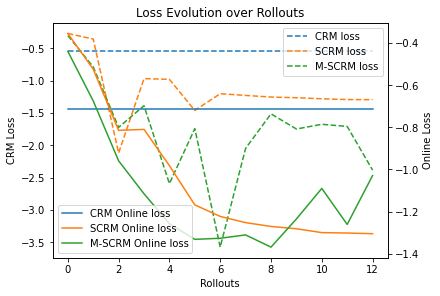

In [34]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(single_crm_loss_, '--', label='CRM loss')
ax.plot(mean_seq_crm_losses, '--', label='SCRM loss')
ax.plot(mean_multi_seq_crm_losses, '--', label='M-SCRM loss')

ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(single_online_loss_, label='CRM Online loss')
ax2.plot(mean_seq_online_losses, label='SCRM Online loss')
ax2.plot(mean_multi_seq_online_losses, label='M-SCRM Online loss')

ax2.set_ylabel('Online Loss')
ax2.legend(loc='lower left')